In [1]:
import warnings
warnings.filterwarnings('ignore')
import mglearn
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import seaborn as sns


# **Punto 2 (parte 1) y Punto 3**

# **NeurIPS 2024 - Predict New Medicines with BELKA**

## **Contexto**

Los farmacos de moleculas pequeñas son sustacioas químicas,  estas sustancias tienen como objetivos inhibir la actividad de dianas proteicas individuales. La idea es identificar cuales farmacos, logran inhibir la actividad de las proteinas. Normalmente el enfoque es fabricar las moleculas fisicamente una por una y probarla con cada proteina de interés y combrobar si estas interactuan. Visto de esta forma este proceso es un proceso que requiere de mucho tiempo, es por esta razón que se quiere hallar una forma de predecir la unión de las moleculas y proteinas mediante modelos de clasificación.
Los datos se recompilaron mediante la tecnología de biblioteca quimica codificada por ADN(DEL).

*Tomado de: [NeurIPS 2024 - Predice nuevos medicamentos con BELKA](https://www.kaggle.com/competitions/leash-BELKA/data)*

**Notación SMILE**

La notación SMILE es utilizada para representar la estructura de las moleculas quimicas, codificando el grafo molecular,incluyendo atomos, enlaces y contevtividad en una secuencua de caracteres.

**Datos:** 
- **id**: Identificación única para el ejemplo de la unión molécula-proteina.
- **buildingblock1_smiles**: Estructura del primer bloque de construcción en SMILE.
- **buildingblock2_smiles**: Estructura del segundo bloque de construcción en SMILE.
- **buildingblock3_smiles** - Estructura del tercer bloque de construcción en SMILE.
- **molecule_smiles** - La estructura de la molécula completamente ensamblada, en SMILES. Esto incluye los tres bloques de construcción y el núcleo de triazina.
- **protein_name**: El nombre de la proteína objetivo
- **binds** : Una etiqueta de clase binaria que indica si la molécula se une a la proteína.

**Análisis de las proteinas objetivo:**
1. **EPHX2 (sEH)**
La epóxido hidrolasa 2, codificada por el gen EPHX2 y conocida como sEH, desempeña un papel en la hipertensión y la diabetes. Los inhibidores de sEH han progresado hasta estudios clínicos. Durante el pasado, EPHX2/sEH se evaluó usando DEL y se optaron por resultados con aprendizaje automático, aunque los datos no se han dado a conocer. EPHX2/sEH se incluyó en las evaluaciones con el propósito de posibilitar a los participantes comparar el rendimiento de sus modelos con resultados anteriores.

2. **BRD4**
La proteína BRD4, codificada por el gen BRD4, está unida a Histonas en el núcleo y regula la transcripción del ADN, lo cual tiene un impacto en la expresión genética. Los dominios bromodominios, tales como BRD4, están relacionados con la progresión del cáncer, y se han puesto en marcha terapias que inhibien sus funciones. BRD4 ha sido previamente estudiado con enfoques DEL, pero los resultados no fueron publicados; se incluyó en evaluaciones para probar moléculas candidatas en oncología.

3. **ALB (HSA)**
La albúmina sérica, codificada por el gen ALB y conocida como HSA, es la proteína más abundante en el sistema cardiovascular. Su función fundamental radica en mantener la presión osmótica y transportar diversas moléculas, tales como hormonas y ácidos grasos. Dado su elevada concentración, la albúmina tiene un impacto en la absorción y distribución de medicamentos en el cuerpo, por lo que disminuir la unión de los medicamentos con esta proteína puede incrementar su efectividad.

En los datos suministrados en la plataforma de Kaggle, se pueden obtener un conjunto de datos de entrenamiento, que es el que será usado para este estudio y un conjunto de test, este conjunto de test no será usado para este estudio, puesto que no cuenta con la presencia de la variable respuesta, es decir, no cuenta con la variable binaria que indica si se unió o no la proteína con la molécula, por tanto no se podrá medir de forma adecuada si los modelos lanzados funcionan bien en el conjunto de test, por estas razones se dividirá el conjunto de entrenamiento original para poder tener un conjunto de test adecuado.

## **EDA: Punto 2**

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

### **Conjunto de entrenamiento**

#### **Preliminares**

In [2]:
datos=pd.read_csv("C:/Users/fonta/OneDrive/Escritorio/train.csv")

In [4]:
datos.head(3)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0


In [5]:
datos.shape

(295246830, 7)

Vemos que el dataset cuenta con casi 300 millones de registro y un total de 7 columnas.

In [56]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246830 entries, 0 to 295246829
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            int64 
 1   block1        object
 2   block2        object
 3   block3        object
 4   molecule      object
 5   protein_name  object
 6   binds         int64 
dtypes: int64(2), object(5)
memory usage: 15.4+ GB


Cada una de las variables se presentan como categoricas, menos las variables de la *id* y *bins* que es la variable que contiene la clasificación binaria de si se dió o no la unión. 
El resto de variables tienen la notación SMILE de cada uno de los bloques de construcción y la molecula completa.

In [3]:
datos.columns=["id","block1","block2", "block3", "molecule","protein_name","binds"]

In [4]:
datos.columns

Index(['id', 'block1', 'block2', 'block3', 'molecule', 'protein_name',
       'binds'],
      dtype='object')

**Bloque 1**

In [12]:
print('Valores unicos',len(datos["block1"].unique()))
print('Cantidad de datos faltantes',datos["block1"].isna().sum())

Valores unicos 271
Cantidad de datos faltantes 0


**Bloque 2**

In [11]:
print('Valores unicos',len(datos["block2"].unique()))
print('Cantidad de datos faltantes',datos["block2"].isna().sum())

Valores unicos 693
Cantidad de datos faltantes 0


**Bloque 3**

In [13]:
print('Valores unicos',len(datos["block3"].unique()))
print('Cantidad de datos faltantes',datos["block3"].isna().sum())

Valores unicos 872
Cantidad de datos faltantes 0


Con los análisis anteriores tenemos información importante, ninguno de los 3 bloques de construcción contiene datos faltantes y además vemos que el bloque uni tienen un total de 271 registros únicos, el bloque 2 tiene 693 registros únicos y el bloque 3 tiene 872 registros únicos. Esto podría traernos un poco de complicaciones mas adelante al momento de codificar nuestras variables para el modelo.

**Moleculas**

In [14]:
print('Valores unicos',len(datos["molecule"].unique()))
print('Cantidad de datos faltantes',datos["molecule"].isna().sum())

Valores unicos 98415610
Cantidad de datos faltantes 0


En el caso de la variable "Molecule", en la cual se tienen registro de las estructuras moleculares, se tienen un total de 98'415.610 de registros únicos y 0 datos faltantes, se tiene una gran cantidad valores únicos en el conjunto de train.

In [15]:
datos["molecule"].value_counts()

molecule
C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1                       3
O=C1CSC(Nc2nc(Nc3cnc(Cl)cc3Cl)nc(Nc3ccc(C(F)(F)F)cc3C(=O)N[Dy])n2)=N1                        3
O=C1CSC(Nc2nc(Nc3ccc(C(F)(F)F)cc3C(=O)N[Dy])nc(Nc3n[nH]c4cc(Cl)ccc34)n2)=N1                  3
O=C1CSC(Nc2nc(Nc3ccc(C(F)(F)F)cc3C(=O)N[Dy])nc(Nc3n[nH]c4c(F)c(F)ccc34)n2)=N1                3
O=C1CSC(Nc2nc(Nc3ccc(C(F)(F)F)cc3C(=O)N[Dy])nc(Nc3n[nH]c4c(Cl)cc([N+](=O)[O-])cc34)n2)=N1    3
                                                                                            ..
Cc1cc(Nc2nc(NCc3nnn(C)c3C(F)F)nc(N[C@@H](Cc3ccc(F)cc3)C(=O)N[Dy])n2)ccn1                     3
Cc1cc(Nc2nc(Nc3ccc(=O)n(C)c3)nc(N[C@@H](Cc3ccc(F)cc3)C(=O)N[Dy])n2)ccn1                      3
Cc1cc(Nc2nc(NCc3cn(C)nc3Br)nc(N[C@@H](Cc3ccc(F)cc3)C(=O)N[Dy])n2)ccn1                        3
Cc1cc(Nc2nc(NCc3cn(C)c(=O)[nH]c3=O)nc(N[C@@H](Cc3ccc(F)cc3)C(=O)N[Dy])n2)ccn1                3
[N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc3ccc(F)cc

Los resultados anteriores nos dejan ver que cada uno de los registros únicos se repiten 3 veces dentro del dataset, esto pues se tienen registro de cada una de las moleculas con cada una de las 3 proteinas para saber si con alguna de las 3 proteinas se obtuvo una reacción o no, es por esta razón que el dataset tienen como tamaño, el triple de los registros únicos de moleculas.

**Bins**

Podemos hacer un análisis para ver como se comporta la proporción de nuestra variable de clasificación binaria, la variable objetivo *bins*.

In [11]:
datos["binds"].value_counts()

binds
0    293656924
1      1589906
Name: count, dtype: int64

In [14]:
(1589906/len(datos))*100

0.5385006165857903

EL comprtamiento de nuestra variable respuesta es un poco preocupante puesto que existe un gran desequilibrio en el DataFrame, el 99% de los registros en la variable binaria responden a la categoría 0 y solo un 0.54% responden a la categoría 1, esto es un factor importante al momento de entrenar, validar y testear cualquier modelo.

***NOTA:***
Es notable la gran dimensión de registros que se tienen en el dataset, para trabajar con esa cantidad de datos se necesitan unos recursos adecuados. En este análisis y por fines de reducir la complejidad de todos los códigos y la carga computacional que implica trabajar con millones de datos, se trabajará de manera independiente para cada proteina, es decir, se filtrará el data set por cada proteina y se tomará una muestra significativa en cada uno de ellos para crear los respetivos modelos de clasificación.

#### **Filtro por proteina**

In [5]:
datos["protein_name"].unique()

array(['BRD4', 'HSA', 'sEH'], dtype=object)

In [4]:
brd4=datos[datos["protein_name"]=="BRD4"]

In [7]:
brd4["binds"].value_counts()

binds
0    97958646
1      456964
Name: count, dtype: int64

In [12]:
ceros=(97958646/len(brd4))*100
unos=(456964/len(brd4))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.53567935005432
Proporción de la categoría 1:  0.4643206499456743


In [4]:
hsa=datos[datos["protein_name"]=="HSA"]

In [9]:
hsa["binds"].value_counts()

binds
0    98007200
1      408410
Name: count, dtype: int64

In [15]:
ceros=(98007200/len(hsa))*100
unos=(408410/len(hsa))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.58501501946692
Proporción de la categoría 1:  0.41498498053306787


In [7]:
seh=datos[datos["protein_name"]=="sEH"]

In [10]:
seh["binds"].value_counts()

binds
0    97691078
1      724532
Name: count, dtype: int64

In [16]:
ceros=(97691078/len(seh))*100
unos=(724532/len(seh))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.26380378072137
Proporción de la categoría 1:  0.7361962192786287


Al filtrar vemos que la diferencia entre las categorías se mantiene en los dataframe, nuestro objetivo de aquí en adelante es trabajar con estos 3 dataframe por separado, con el fin de lanzar modelos que puedan clasificar si se da o no la unión entre alguna de las 3 proteinas con distintas moleculas, es necesario tratar las variables de cada conjunto de datos para establecer cual será el conjunto X de entrenamiento en cada uno de los modelos.

#### ***SEH: Hidrolasa de Epóxido Soluble.***

##### **Análisis inicial.**

In [17]:
seh.shape

(98415610, 7)

Vemos que ahora nuetro dataframe cuenta con 98'415.610 registros, que es mucho menor que el anterior, pero aun así con nuestros recursos es muy dificil de procesar y modelar ese gran conjunto de datos es por eso que nos quedaremos solo con 100.000 registros elegidos al azar dentreo de los 98 millones.

In [8]:
seh_final, _ = train_test_split( seh, train_size = 100000,  stratify = seh['binds'], random_state=11)

In [10]:
seh_final.to_csv('final_seh_',index=False)

In [13]:
seh_final=pd.read_csv("C:/Users/fonta/OneDrive/Documentos/CDD/6. Sexto semestre/Machine learning/Primer parcial/Parcial_practico/final_seh_")

In [25]:
seh_final.head()

,id,block1,block2,block3,molecule,protein_name,binds
0,147239129,O=C(Nc1c(Cl)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CNC(=O)COCCN.Cl,CN(CCN)C1CCOCC1,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,sEH,0
1,257990426,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Cl.NCCN1CCCS1(=O)=O,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,sEH,0
2,180571076,O=C(Nc1ccc(Br)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1ccc2[nH]ccc2c1,Cc1ccc(N)nn1,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,sEH,0
3,186946937,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCc1ccc(-c2c[nH]c(=O)[nH]c2=O)cc1,Nc1ccsc1.O=C(O)C(=O)O,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,sEH,0
4,207543668,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,Cl.NCC(=O)N1CCCO1,Nc1c(O)ncnc1O,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,sEH,0


In [26]:
len(seh_final['molecule'].unique())

100000

Luego de hacer la selección aleatoria estratificada para reducir la cantidad de registros en el dataset de SEH, vemos que la cantidad de moléculas únicas en la selección es igual a la cantidad de registros; es por tanto que podemos decir que todas las moléculas son únicas. Así podemos decir que la estructura de la molécula en notación SMILE cumple la función de un estilo de identificación de la unión de los bloques. Esta variable será retirada al momento de crear el dataframe final para el entrenamiento de los modelos, ya que es posible que al incluirla pueda crear sobre ajuste.

In [27]:
seh_final["binds"].value_counts()

binds
0    99264
1      736
Name: count, dtype: int64

In [28]:
ceros=(99264/len(seh_final))*100
unos=(736/len(seh_final))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.264
Proporción de la categoría 1:  0.736


Luego de hacer el proceso de extraer 100.000 datos de la muestra orginal, vemos que las proporciones en la variable binearia, son similares al grupo de datos original, por tanto al cambiar el tamaño de los datos no hemos alterado la distribución de nuestra variable respuesta.

In [29]:
seh_final.describe(include=[object])

,block1,block2,block3,molecule,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,867,100000,1
top,O=C(Nc1cc(C(=O)O)ccc1Br)OCC1c2ccccc2-c2ccccc21,CC1(CCCCN)OCCO1,CSc1nnc(CN)s1,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,sEH
freq,418,261,226,1,100000


Si recordamos al incio de este análisis, veíamos la cantidad de datos únicos que se tenían en el set de datos orginales, en este data set con menos registros se mantienen la misma cantidad de registros únicos en las variaables "block1", "Block2"y "Block3".

##### **Codificación de las variables categoricas.**

In [14]:
to_encode=seh_final.copy()
to_encode=to_encode.reset_index()

Se hará la codificación de cada una de los valores únicos en las variables categóricas de interés, esto con el fin de poder ser incluídas en los modelos que se implementaran mas adelante, para cumplur esta acción se hará uso de la función OneHotEncoder().

In [15]:
categorical_columns = ['protein_name', 'block1', 'block2', 'block3']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(to_encode[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([to_encode, one_hot_df], axis=1)
df_encoded_seh = df_encoded.drop(categorical_columns, axis=1)


In [32]:
df_encoded_seh.head()

,index,id,molecule,binds,protein_name_sEH,block1_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,block3_Nc1ncnc(=O)[nH]1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1ncnc2[nH]cnc12,block3_Nc1ncnc2[nH]ncc12,block3_Nc1ncnc2c1ncn2C1CCCCO1,block3_Nc1ncncc1Br,block3_Nc1nnc(S)s1,block3_Nc1nncs1,block3_Nc1nnn[nH]1,block3_Nc1noc2ccc(F)cc12
0,0,147239129,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,257990426,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,180571076,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,186946937,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,207543668,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como mencionamos anteriormente, la variable "molecule" y la variable "id" serán retiradas del dataframe, puesto que no aportan en nada al modelo al ser solo información de identificación.

In [16]:
df_encoded_seh.drop(columns=['id','molecule'], inplace=True)

In [17]:
df_encoded_seh.head()

,index,binds,protein_name_sEH,block1_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,block3_Nc1ncnc(=O)[nH]1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1ncnc2[nH]cnc12,block3_Nc1ncnc2[nH]ncc12,block3_Nc1ncnc2c1ncn2C1CCCCO1,block3_Nc1ncncc1Br,block3_Nc1nnc(S)s1,block3_Nc1nncs1,block3_Nc1nnn[nH]1,block3_Nc1noc2ccc(F)cc12
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con este dataset final procederemos a utilizar la función de **chi2** y **SelectKBest** del paquete de **scikit-learn**, con el fin de escoger 100 de las variables codificadas, de tal manera que las mismas expliquen de mejor manera la variable objetivo **Bins**.

##### **Reducción de multicolinialidad.**

In [18]:
y_train_seh = df_encoded_seh['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best1 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new1 = k_best1.fit_transform(df_encoded_seh, y_train_seh)

selected_features = k_best1.get_support(indices=True)  # Obtener los índices de las características seleccionadas
x_train_seh = df_encoded_seh.iloc[:, selected_features]

Con lo anterior tenemos como resultado nuestra matriz X de entrenamiento para la proteina seh y nuestro *y* de entrenamiento, se muestran a continuación.

In [19]:
x_train_seh.head()

,index,binds,block1_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,block1_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,block1_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,block1_O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,block1_O=C(Nc1ccc(C(=O)O)nc1)OCC1c2ccccc2-c2ccccc21,...,block3_Nc1c2c(cc3c1CCC3)CCC2,block3_Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1,block3_Nc1cc(Cl)ccc1F,block3_Nc1cc(F)c(F)cc1[N+](=O)[O-],block3_Nc1ccc2c(c1)CNCC2,block3_Nc1cccc2ocnc12,block3_Nc1cncc(F)c1,block3_Nc1n[nH]c2ccc([N+](=O)[O-])cc12,block3_Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],block3_Nc1ncco1
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y_train_seh

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: binds, Length: 100000, dtype: int64

#### ***HSA: Soluble Epoxide Hydrolase 2.***

##### **Análisis inicial.**

De igual manera como se hizo con la proteina **SEH**, tomaremos una muestra aleatoria estratificada del conjunto de datos filtrados de la base de datos original, se realiza esta acción puesto que es casi imposible con los recursos que se tienen en este momento trabajar con esa gran cantidad de datos, así que hacemos este ejercicio con el proposito de que algún día podamos lograr estos retos y mas.

In [6]:
hsa_final, _ = train_test_split( hsa, train_size = 100000,  stratify = hsa['binds'], random_state=11)

In [7]:
hsa_final.to_csv('final_hsa_',index=False)

In [21]:
hsa_final=pd.read_csv("C:/Users/fonta/OneDrive/Documentos/CDD/6. Sexto semestre/Machine learning/Primer parcial/Parcial_practico/final_hsa_")

In [9]:
hsa_final.head()

,id,block1,block2,block3,molecule,protein_name,binds
0,79451005,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Nc1ccnc(Cl)c1,N#Cc1cccc(N)n1,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,HSA,0
1,251510695,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,Nc1ccc(O)cn1,Cn1ncc2cc(N)ccc21,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,HSA,0
2,50733376,Cc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCCOC1CCS(=O)(=O)C1,Cn1nnc(N)n1,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,HSA,0
3,62661181,Cn1cc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Cl.NCC1CC(C(N)=O)=NO1,Nc1ccc(F)c(C(F)(F)F)c1,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,HSA,0
4,266507149,O=C(O)C[C@H](Cc1ccc(C(F)(F)F)cc1)NC(=O)OCC1c2c...,Cl.Nc1ccc(O)cc1Cl,Cc1ccnc(N)c1,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,HSA,0


In [11]:
hsa_final["binds"].value_counts()

binds
0    99585
1      415
Name: count, dtype: int64

In [12]:
ceros=(99585/len(hsa_final))*100
unos=(415/len(hsa_final))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.58500000000001
Proporción de la categoría 1:  0.415


Es importante notar que la proporción de las categorías de la variable respuesta se mantiene similar a las proporciones en los dataframes originales.

In [13]:
hsa_final.describe(include=[object])

,block1,block2,block3,molecule,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(Nc1cc(Br)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1c(F)cccc1N1CCCC1,Cc1nc(Cl)c(N)c(Cl)n1,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,HSA
freq,435,281,224,1,100000


No hay registros nuevos en las demas variables como lo muestra la describción, se tienen 271 valores únicos en Block1, 693 en Block2 y 871 en Block3.

##### **Codificacíon de las variables categóricas.**

In [22]:
to_encode=hsa_final.copy()
to_encode=to_encode.reset_index()

Se seguirán los mismos pasos de codificación usado en la proteina SEH, esta vez para la proteina HSA. 

In [23]:
categorical_columns = ['protein_name', 'block1', 'block2', 'block3']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(to_encode[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded_hsa = pd.concat([to_encode, one_hot_df], axis=1)
df_encoded_hsa = df_encoded_hsa.drop(categorical_columns, axis=1)

In [24]:
df_encoded_hsa.head()

,index,id,molecule,binds,protein_name_HSA,block1_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,block3_Nc1ncnc(=O)[nH]1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1ncnc2[nH]cnc12,block3_Nc1ncnc2[nH]ncc12,block3_Nc1ncnc2c1ncn2C1CCCCO1,block3_Nc1ncncc1Br,block3_Nc1nnc(S)s1,block3_Nc1nncs1,block3_Nc1nnn[nH]1,block3_Nc1noc2ccc(F)cc12
0,0,79451005,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,251510695,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,50733376,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,62661181,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,266507149,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De igual forma eliminamos las columnas "id" y "molecule".

In [25]:
df_encoded_hsa.drop(columns=['id','molecule'], inplace=True)

In [26]:
df_encoded_hsa.head()

,index,binds,protein_name_HSA,block1_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,block3_Nc1ncnc(=O)[nH]1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1ncnc2[nH]cnc12,block3_Nc1ncnc2[nH]ncc12,block3_Nc1ncnc2c1ncn2C1CCCCO1,block3_Nc1ncncc1Br,block3_Nc1nnc(S)s1,block3_Nc1nncs1,block3_Nc1nnn[nH]1,block3_Nc1noc2ccc(F)cc12
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pasamos ahora a reducir la multicolinialidad entre nuestras variables.

##### **Reducción de multicolinialidad.**

In [27]:
y_train_hsa = df_encoded_hsa['binds']
k_best = SelectKBest(score_func=chi2, k=100)
X_new = k_best.fit_transform(df_encoded_hsa, y_train_hsa)

selected_features = k_best.get_support(indices=True)
hsa_train = df_encoded_hsa.iloc[:, selected_features]

In [28]:
hsa_train.head()

,index,binds,block1_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,block1_Cc1ccc(C(=O)O)cc1NC(=O)OCC1c2ccccc2-c2ccccc21,block1_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(Nc1cc(C(=O)O)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,...,block3_Nc1cccc2ocnc12,block3_Nc1cn[nH]c1,block3_Nc1cncc(F)c1,block3_Nc1n[nH]c2cc(F)ccc12,block3_Nc1nc(Cl)c2[nH]cnc2n1,block3_Nc1nc2c(s1)CN(C(=O)OCc1ccccc1)CC2,block3_Nc1nc[nH]n1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1nncs1,block3_Nc1nnn[nH]1
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Siendo así el dataframe anterior nuestro conjunto de entrenamiento para los modelos de la proteina HSA, y se mantiene nuestra variable respuesta "bins".

In [29]:
y_train_hsa

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: binds, Length: 100000, dtype: int64

#### ***BRD4: Bromodomain-containing protein 4***

##### **Análisis inicial.**

In [5]:
brd4_final, _ = train_test_split( brd4, train_size = 100000,  stratify = brd4['binds'], random_state=11)

In [6]:
brd4_final.to_csv('final_brd4_',index=False)

In [30]:
brd4_final=pd.read_csv("C:/Users/fonta/OneDrive/Documentos/CDD/6. Sexto semestre/Machine learning/Primer parcial/Parcial_practico/final_brd4_")

In [95]:
brd4_final.head()

,id,block1,block2,block3,molecule,protein_name,binds
0,100174431,O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...,Nc1nc(-c2cccnc2)cs1,Cc1nnsc1CN,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,BRD4,0
1,288634638,O=C(O)[C@H]1CC2CCCCC2N1C(=O)OCC1c2ccccc2-c2ccc...,Nc1ccncc1[N+](=O)[O-],Nc1nc2nc[nH]c2c(=O)[nH]1,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,BRD4,0
2,43808760,C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...,COc1c(F)cc(N)cc1F,Nc1ccc(F)cc1CO,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,BRD4,0
3,91037118,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,Cl.NCCOC1CCS(=O)(=O)C1,Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,BRD4,0
4,3471777,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COC(=O)c1scnc1N,NCC1CSCCN1Cc1ccccc1,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,BRD4,0


In [9]:
len(brd4_final['molecule'].unique())

100000

In [10]:
brd4_final["binds"].value_counts()

binds
0    99536
1      464
Name: count, dtype: int64

In [11]:
ceros=(99536/len(brd4_final))*100
unos=(464/len(brd4_final))*100

print('Proporción de la categoría 0: ', ceros)
print('Proporción de la categoría 1: ', unos)

Proporción de la categoría 0:  99.536
Proporción de la categoría 1:  0.464


In [12]:
brd4_final.describe(include=[object])

,block1,block2,block3,molecule,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(N[C@@H](Cc1cc(F)c(F)c(F)c1)C(=O)O)OCC1c2cc...,NCCC(=O)NC1CCCC1,Cc1cc2cc(CN)ccc2[nH]1,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,BRD4
freq,436,272,233,1,100000


Con estos análisis iniciales, se nota que este conjunto de datos de la proteina brd4 tiene el mismo comportamiento de los otros dos, lo cual es importante al momento de modelar.

##### **Codificación de las variables categóricas.**

In [31]:
to_encode=brd4_final.copy()
to_encode=to_encode.reset_index()

In [32]:
categorical_columns = ['protein_name', 'block1', 'block2', 'block3']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(to_encode[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded_brd4 = pd.concat([to_encode, one_hot_df], axis=1)
df_encoded_brd4 = df_encoded_brd4.drop(categorical_columns, axis=1)

In [33]:
df_encoded_brd4.drop(columns=['id','molecule'], inplace=True)

In [99]:
df_encoded_brd4.head()

,index,binds,protein_name_BRD4,block1_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,block1_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,block3_Nc1ncnc(=O)[nH]1,block3_Nc1ncnc(Cl)c1Cl,block3_Nc1ncnc2[nH]cnc12,block3_Nc1ncnc2[nH]ncc12,block3_Nc1ncnc2c1ncn2C1CCCCO1,block3_Nc1ncncc1Br,block3_Nc1nnc(S)s1,block3_Nc1nncs1,block3_Nc1nnn[nH]1,block3_Nc1noc2ccc(F)cc12
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que se ha completado la codificación del conjunto de datos de la proteina "BRD4". Pasamos al ultimo paso que es reducir la dimensión del df, quedandonos con las 100 mejores caracteristicas que explican la variable respuesta "bins".

##### **Reducción de multicolinialidad**

In [34]:
y_train_brd4 = df_encoded_brd4['binds']
k_best = SelectKBest(score_func=chi2, k=100)
X_new = k_best.fit_transform(df_encoded_brd4, y_train_brd4)

selected_features = k_best.get_support(indices=True)
brd4_train = df_encoded_brd4.iloc[:, selected_features]

In [35]:
brd4_train.head()

,index,binds,block1_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,block1_N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1,block1_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,block1_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,...,block3_Nc1cc(Cl)c(O)c(Cl)c1,block3_Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],block3_Nc1ccc2[nH]ncc2c1,block3_Nc1ccc2c(c1)CCC2=O,block3_Nc1ccc2c(c1)CNC2=O,block3_Nc1ccc2c(c1)COC2=O,block3_Nc1cccnc1F,block3_Nc1nc2ccccc2s1,block3_Nc1nc2nc[nH]c2c(=O)[nH]1,block3_Nc1nccs1
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El conjunto anterior será nuestro set de entrenamiento para los modelos de la proteina **BRD4** y así mismo su conjunto Y en el entrenamiento será "bins".

In [36]:
y_train_brd4

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: binds, Length: 100000, dtype: int64

# **Modelación: Punto 3**

Como se explicó anteriormente, en esta sección se implementaran 3 modelos, uno por cada proteína objetivo con el fin de predecir si dada unos bloques de construcción de una molécula se da la unión con una de las 3 proteínas, se implementarán modelos de clasificación vistos en clase esta vez serán K-NN y regresión logística.

### ***SEH***

In [37]:
X=x_train_seh.drop(columns=['binds'])
y=y_train_seh

In [38]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,stratify=y, random_state=11)

#### **K-NN**

In [39]:
pipeline = Pipeline([('scaler',StandardScaler()),('knn', KNeighborsClassifier())])

param_grid = [{
    'knn__n_neighbors':range(3,15),
    'knn__weights': ['uniform', 'distance']  
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

grid_search_k = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_k.fit(X_trainval, y_trainval)

best_parameters = grid_search_k.best_params_
best_score = grid_search_k.best_score_

model_pred_knn = grid_search_k.predict(X_test)
prob_knn = grid_search_k.predict_proba(X_test)[:, 1]

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamiento: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_knn))

Mejores parámetros:  {'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Mejor score de entrenamiento:  0.8168980398319349
Score en el conjunto de test:  0.8146045109396463


Al hacer el respectivo GridSearch con Validación Cruzada nos arroja que el mejor parámetro para le modelo de K-NN es de K=14 vecinos más cercanos, con este parámetro se obtiene una métrica de ROC_AUC de 0.82 aproximadamente, teniendo en cuenta que esta métrica mide la capacidad que tiene el modelo de distinguir entre clases tiene todo el sentido que el modelo obtenga un buen AUC, puesto que el 99% de las clases de la variable respuesta es la 0, habría que revisar que pasa con las demás métricas. Vemos además que el score obtenido en el test, no es muy diferente, por tanto, no existe un sobre ajuste.

#### **Regresión logistica**

In [40]:
pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])

param_grid = [{
    'logreg__C': [0.01, 0.1, 1, 10, 100] 
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_lr.fit(X_trainval, y_trainval)

best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

model_pred_lr = grid_search_lr.predict(X_test)
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamiento: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_lr))

Mejores parámetros:  {'logreg__C': 0.01}
Mejor score de entrenamiento:  0.9459628169486717
Score en el conjunto de test:  0.9460246983012361


En el modelo de regresión logística para la proteína SEH con mayor score AUC es de 0.94 con el mejor parámetro c=0.01, vemos que el score del modelo de regresión logística es mayor que en modelo de K-NN, lo que quiere decir que el modelo que mejor diferencia las clases es la regresión logística. Este mejor modelo se obtiene con el parámetro c =0.01 lo que indica que el modelo está regularizado y su complejidad no es tan alta, de igual forma no existe sobre ajuste, no hay diferencia significativa entre los scores de entrenamiento y test.

#### **Métricas**

In [41]:

model_pred_knn = grid_search_k.predict(X_test)
model_pred_lr = grid_search_lr.predict(X_test)

prob_knn = grid_search_k.predict_proba(X_test)[:, 1]
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

tabla2 = {
    '': ['K-NN', 'Regresión Logística'],
    'Precisión': [
        precision_score(y_test, model_pred_knn, average='binary'),
        precision_score(y_test, model_pred_lr, average='binary')
    ],
    'Recall': [
        recall_score(y_test, model_pred_knn, average='binary'),
        recall_score(y_test, model_pred_lr, average='binary')
    ],
    'F1 Score': [
        f1_score(y_test, model_pred_knn, average='binary'),
        f1_score(y_test, model_pred_lr, average='binary')
    ],
    'AUC': [
        roc_auc_score(y_test, prob_knn),  
        roc_auc_score(y_test, prob_lr)  
    ]
}

tabla = pd.DataFrame(tabla2)
tabla


,,Precisión,Recall,F1 Score,AUC
0,K-NN,0.483871,0.244565,0.324910,0.814605
1,Regresión Logística,0.607843,0.336957,0.433566,0.946025


Si no ponemos a pensar la "La métrica de negocio" para este estudio es reducir los falsos positivos,  ya que el interés  del estudio es predecir si la molécula y la proteína se unen o no, no es favorecedor tener falsos positivos. Con esto en mente debemos revisar la métrica **Precisión**, vemos que el mejor score en precisión se da en el modelo de regresión logística con un score de 0.61 aproximadamente, a diferencia del modelo K-NN que obtuvo un precisión de 0.48.

#### **Curvas ROC y matrices de confución**

**Curvas ROC**

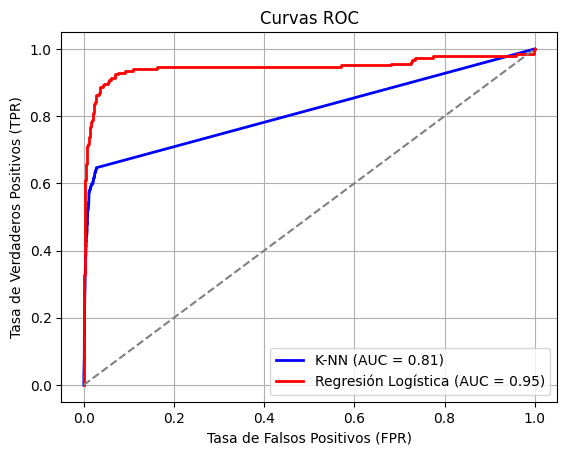

In [75]:

probs_knn = grid_search_k.predict_proba(X_test)[:, 1] 
probs_lr = grid_search_lr.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_lr)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'K-NN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Regresión Logística (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Representación gráfica de lo dicho anteriormente, mostrando que la regresión logística está más cerca de la esquina superior izquierda, confirmando que el modelo de reg. logística tiene mejor distinción entre las clases.

**Matrices de confución**

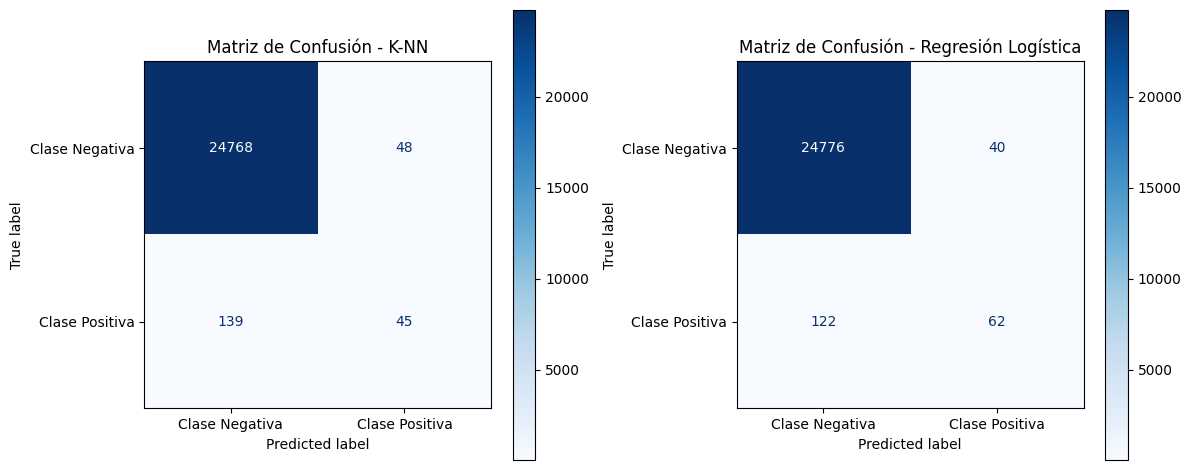

In [84]:
conf_matrix_knn = confusion_matrix(y_test, model_pred_knn)
conf_matrix_lr = confusion_matrix(y_test, model_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Matriz de Confusión - K-NN')

ConfusionMatrixDisplay(conf_matrix_lr, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Matriz de Confusión - Regresión Logística')

plt.tight_layout()
plt.show()

Las matrices de confusión nos muestran claramente en que afecta tener un conjunto de entrenamiento tan desbalanceado, en ambos modelos se entrenó muy bien como predecir la clase negativa, esto por consecuencia de tener la clase negativa como mayoritaria en el conjunto de entrenamiento, así, si vemos la cantidad de predicciones negativas que en realidad eran positivas son proporcionales en ambos modelos, al igual que los falsos positivos.

### ***HSA***

In [42]:
X=hsa_train.drop(columns=['binds'])
y=y_train_hsa

In [43]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,stratify=y, random_state=8)

#### **K-NN**

In [44]:
pipeline = Pipeline([('scaler',StandardScaler()),('knn', KNeighborsClassifier())])

param_grid = [{
    'knn__n_neighbors':[10,15,25,30,],
    'knn__weights': ['uniform', 'distance'] 
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

grid_search_k = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_k.fit(X_trainval, y_trainval)

best_parameters = grid_search_k.best_params_
best_score = grid_search_k.best_score_

model_pred_knn = grid_search_k.predict(X_test)
prob_knn = grid_search_k.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, prob_knn)

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamiento: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_knn))

Mejores parámetros:  {'knn__n_neighbors': 30, 'knn__weights': 'distance'}
Mejor score de entrenamiento:  0.7269284811010341
Score en el conjunto de test:  0.6988078097192011


Para este primer modelo de la proteína HSA, luego de implementar la respectiva validación cruzada y GridSearch se escogió como mejor modelo a aquel con parámetro k = 30, con un score en el entrenamiento de 0.72, pero vemos que si comparamos este score con el score obtenido en el conjunto de test que es de 0.70 aproximadamente, se llega a la conclusión de que hay un pequeño sobre ajuste, se debería evaluar si la diferencia es significativa o no.

#### **Regresión logística.**

In [45]:
pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])

param_grid = [{
    'logreg__C': [0.01, 0.1, 1, 10, 100] 
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_lr.fit(X_trainval, y_trainval)

best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

model_pred_lr = grid_search_lr.predict(X_test)
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamiento: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_lr))

Mejores parámetros:  {'logreg__C': 0.1}
Mejor score de entrenamiento:  0.8833895826752356
Score en el conjunto de test:  0.9068030700019776


Por parte del modelo de regresión logística, se obtiene que el mejor modelo es aquel con un parámetro c= 0.1 que si vemos es el mismo parámetro del modelo logístico de la primera proteína, el score de este modelo es de 0.88, además en el conjunto de test se obtuvo un buen score, siendo este de 0.90

#### **Métricas.**

In [46]:
model_pred_knn = grid_search_k.predict(X_test)
model_pred_lr = grid_search_lr.predict(X_test)

prob_knn = grid_search_k.predict_proba(X_test)[:, 1]
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

tabla2 = {
    '': ['K-NN', 'Regresión Logística'],
    'Precisión': [
        precision_score(y_test, model_pred_knn, average='binary'),
        precision_score(y_test, model_pred_lr, average='binary')
    ],
    'Recall': [
        recall_score(y_test, model_pred_knn, average='binary'),
        recall_score(y_test, model_pred_lr, average='binary')
    ],
    'F1 Score': [
        f1_score(y_test, model_pred_knn, average='binary'),
        f1_score(y_test, model_pred_lr, average='binary')
    ],
    'AUC': [
        roc_auc_score(y_test, prob_knn),  
        roc_auc_score(y_test, prob_lr)  
    ]
}

tabla = pd.DataFrame(tabla2)
tabla

,,Precisión,Recall,F1 Score,AUC
0,K-NN,0.214286,0.028846,0.050847,0.698808
1,Regresión Logística,0.375000,0.057692,0.100000,0.906803


Evaluando las diferentes métricas presentadas en la tabla anterior, podemos ver que estas son un poco bajas en comparación a las obtenidas en los modelos de la proteína SEH. Evaluando la métrica de negocio, que en este caso es precisión, vemos que en ambos modelos es muy baja, así que estos modelos no están captando de forma correcta la clase positiva de la variable respuesta, esto se verá más claro en la matriz de confusión.

#### **Curvas ROC y matrices de confusión.**

**Curvas ROC**

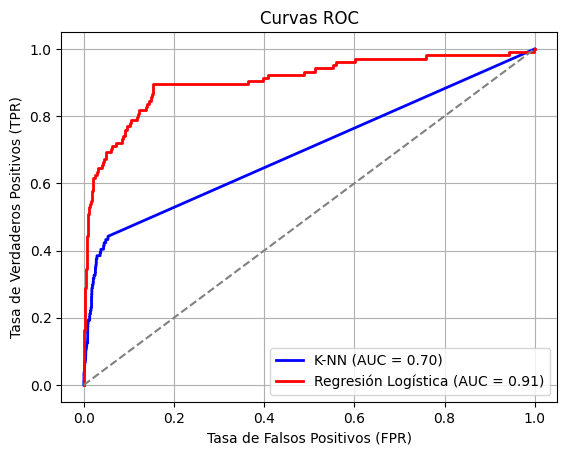

In [126]:
probs_knn = grid_search_k.predict_proba(X_test)[:, 1] 
probs_lr = grid_search_lr.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_lr)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'K-NN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Regresión Logística (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

En los gráficos de las curvas ROC de ambos modelos, vemos como efectivamente el modelo de regresión logística capta de mejor manera las diferentes clases, a diferencia del modelo K-NN que tiene un score más regular.

**Matrices de confisión.**

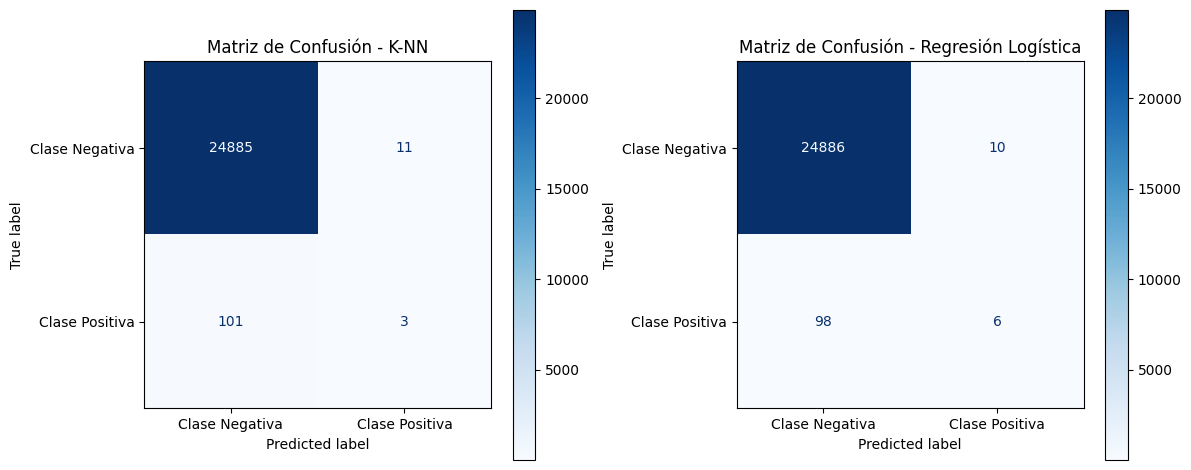

In [127]:
conf_matrix_knn = confusion_matrix(y_test, model_pred_knn)
conf_matrix_lr = confusion_matrix(y_test, model_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Matriz de Confusión - K-NN')

ConfusionMatrixDisplay(conf_matrix_lr, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Matriz de Confusión - Regresión Logística')

plt.tight_layout()
plt.show()

Como lo mencionábamos anteriormente, en ambas matrices se puede observar como el modelo es capaz de predecir muy bien la clase negativa, pero la clase positiva es muy pequeña en comparación, esto por supuesto debido al gran desbalance que se encuentra en el conjunto de entrenamiento, además hablábamos un poco de como la métrica de Precisión es muy baja en ambos modelos y pues se ve claramente porque, ya que los modelos no logran captar bien la clase positiva.

### **BRD4**

In [47]:
X=brd4_train.drop(columns=['binds'])
y=y_train_brd4

In [48]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,stratify=y, random_state=8)

#### **K-NN**

In [49]:
pipeline = Pipeline([('scaler',StandardScaler()),('knn', KNeighborsClassifier())])

param_grid = [{
    'knn__n_neighbors':[30,35,40,45,50,60],
    'knn__weights': ['uniform', 'distance']  
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

grid_search_k = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_k.fit(X_trainval, y_trainval)

best_parameters = grid_search_k.best_params_
best_score = grid_search_k.best_score_

model_pred_knn = grid_search_k.predict(X_test)
prob_knn = grid_search_k.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, prob_knn)

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamiento: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_knn))

Mejores parámetros:  {'knn__n_neighbors': 60, 'knn__weights': 'distance'}
Mejor score de entrenamiento:  0.8257008635190584
Score en el conjunto de test:  0.8658949941521765


Para la tercera proteína de interés, el BRD4, se obtuvo como mejor modelo, aquel con parámetro k=60, con un score en la métrica AUC de 0.82. Siendo este un score bastante adecuado, vemos que no se generó sobre ajuste, puesto que el score en el conjunto de test es de 0.86

#### **Regresión logística.**

In [50]:
pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])

param_grid = [{
    'logreg__C': [0.01, 0.1, 1, 10, 100]  
}]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=k_fold, scoring='roc_auc', n_jobs=-1)

grid_search_lr.fit(X_trainval, y_trainval)

best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

model_pred_lr = grid_search_lr.predict(X_test)
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

print("Mejores parámetros: ", best_parameters)
print("Mejor score de entrenamientp: ", best_score)
print('Score en el conjunto de test: ',roc_auc_score(y_test, prob_lr))


Mejores parámetros:  {'logreg__C': 0.01}
Mejor score de entrenamientp:  0.9250193381948184
Score en el conjunto de test:  0.9633045607480779


Por el lado del modelo de regresión logística vemos que el mejor parámetro no varió entre los otros 2 modelos logísticos con una c=0.01, este caso, para la proteína BRD4 se obtuvo un score en el conjunto de entrenamiento de 0.92 y en el conjunto de test de 0.96, ambos scores bastante buenos y si generar sobre ajuste.

#### **Métricas**

In [132]:
model_pred_knn = grid_search_k.predict(X_test)
model_pred_lr = grid_search_lr.predict(X_test)

prob_knn = grid_search_k.predict_proba(X_test)[:, 1]
prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]

tabla2 = {
    '': ['K-NN', 'Regresión Logística'],
    'Precisión': [
        precision_score(y_test, model_pred_knn, average='binary'),
        precision_score(y_test, model_pred_lr, average='binary')
    ],
    'Recall': [
        recall_score(y_test, model_pred_knn, average='binary'),
        recall_score(y_test, model_pred_lr, average='binary')
    ],
    'F1 Score': [
        f1_score(y_test, model_pred_knn, average='binary'),
        f1_score(y_test, model_pred_lr, average='binary')
    ],
    'AUC': [
        roc_auc_score(y_test, prob_knn),  
        roc_auc_score(y_test, prob_lr)  
    ]
}

tabla = pd.DataFrame(tabla2)
tabla

,,Precisión,Recall,F1 Score,AUC
0,K-NN,0.148148,0.034483,0.055944,0.865895
1,Regresión Logística,0.580645,0.155172,0.244898,0.963305


Si comparamos nuestra métrica de negocio en estos últimos dos modelos, vemos que por parte del K-NN la precisión es bastante baja, lo que nos da a entender que su predicción en la clase positiva no es buena a comparación del modelo logístico que obtuvo un score más moderado de 0.58

#### **Curvas ROC y matrices de confusión**

**Curvas ROC**

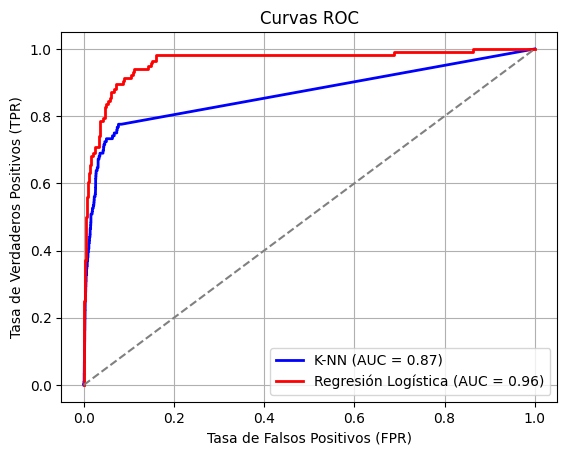

In [133]:
probs_knn = grid_search_k.predict_proba(X_test)[:, 1] 
probs_lr = grid_search_lr.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_lr)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'K-NN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Regresión Logística (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Matrices de confusión**

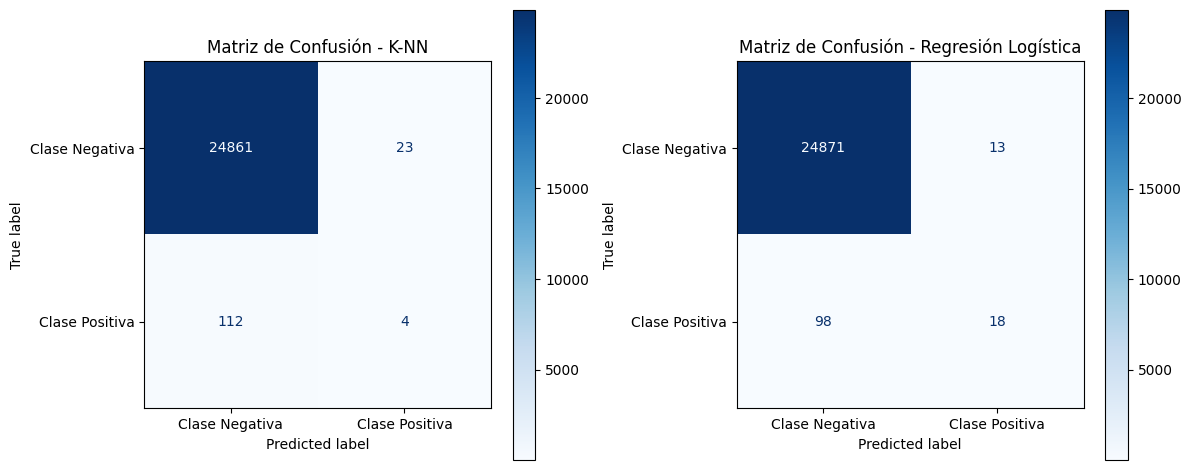

In [134]:
conf_matrix_knn = confusion_matrix(y_test, model_pred_knn)
conf_matrix_lr = confusion_matrix(y_test, model_pred_lr)

# Crear las visualizaciones de las matrices de confusión
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión para K-NN
ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Matriz de Confusión - K-NN')

# Matriz de confusión para Regresión Logística
ConfusionMatrixDisplay(conf_matrix_lr, display_labels=['Clase Negativa', 'Clase Positiva']).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Matriz de Confusión - Regresión Logística')

plt.tight_layout()
plt.show()

Como se mencionó al momento de evaluar las métricas obtenidas, el modelo K-NN en su matriz de confusión muestra gráficamente por qué es que su Recoll es tan bajo, pues su proporción de predicciones correctas que si eran correctas es muy pequeña en comparación a las predicciones de la clase negativa, y como hemos venido diciendo, esto es por consecuencia de trabajar con un conjunto de datos de entrenamiento muy desbalanceado y si recordamos el EDA de este trabajo, el conjunto de datos de la proteína BRD4 era el más desbalanceado de los 3. Del lado derecho, en la matriz del modelo logístico, vemos que este sí logra captar un poco más la categoría positiva a diferencia del otro modelo.